# Tema 2

## Introducción.

En este tema continuaremos mejorando y optimizando la generación de código que se ha mostrado en el tema anterior. Lo primero que vamos a hacer es cargar una serie de librerías que son las que vamos a necesitar, y el código además lo vamos a guardar para reutilizarlo es códigos posteriores.

In [1]:
%%writefile librerias/v0.py

import numpy as np
from sklearn.linear_model import LinearRegression
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
#%matplotlib inline
plt.style.use('fivethirtyeight')

Overwriting librerias/v0.py


In [2]:
%run -i librerias/v0.py
%matplotlib inline

## funciones de orden alto (higher-order).

Para el desarrollo que queremos hacer posteriormente necesitamos antes introducir una herramienta muy poderosa de Python que consiste en las funciones de alto nivel, o también funciones anidadas, las cuales nos permiten devolver funciones mediante la llamada a otra función.

Veamos el siguiente ejemplo, en el que queremos utilizar la función de exponenciación. Esta función necesita dos parámetros para su ejecución, por un lado estaría el valor de la base y por otro el exponente. 

In [3]:
def exponentiation_builder(exponent):
    def skeleton_exponentiation(x):
        return x ** exponent
    return skeleton_exponentiation

Como puede verse en ese código tenemos definido una jerarquía de funciones, de manera que si llamamos a *exponentiation_builder* lo que nos devuelve es otra función pero ya con un determinado exponente. Veamoslo.

In [4]:
expo = exponentiation_builder(4)
expo

<function __main__.exponentiation_builder.<locals>.skeleton_exponentiation(x)>

Como vemos ahora nos está devolviendo una referencia a otra función y se puede utilizar como si de una función se tratara.

In [5]:
expo(2)

16

Realmente con todo este código lo que hemos hecho es calcular $2^4$. Este tipo de funciones anidadas nos va a servir mucho para poder modificar con funciones aspectos tales como la función de coste a utilizar, el optimizador a emplear, etc.

Entonces utilizando esta idea, procedemos a definir dos funciones anidadas que nos permitirán modificar diferentes operadores cuando procedemos a hacer el entrenamiento de un modelo. Estas funciones son las siguientes

In [6]:
%%writefile funciones/make_train_step_fn.py

def make_train_step_fn(model, loss_fn, optimizer):
    """
    Los parámetros de entrada son un modelo, una función de pérdida y un optimizador
    """
    # Builds function that performs a step in the train loop
    def perform_train_step_fn(x, y):
        ## X son los datos del train (var independiente)
        ## y los valores esperados (var. dependiente)
        # Sets model to TRAIN mode
        model.train()
        
        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # Step 3 - Computes gradients for both "a" and "b" parameters
        loss.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optimizer.step()
        optimizer.zero_grad()
        
        # Devuelve los valores de la función de pérdida
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return perform_train_step_fn

Overwriting funciones/make_train_step_fn.py


In [7]:
%run -i funciones/make_train_step_fn.py

Con las funciones indicadas en el bloque anterior, introducimos una gran flexibilidad al modelo, ya que mediante la función más externa podemos pasar el modelo, la función de pérdida y el optimizador, para después con la salida que no de pasarle los datos de la variable independiente y los valores previsto. Con todo ello ya podríamos entrenar nuestro modelo.

Vamos a ver ahora cómo lo podríamos utilizar de una forma práctica.

Primero ejecutamos el fichero de preparación de los datos.

In [8]:
%%writefile data_preparation/v0_0.py

import numpy as np
true_b=1 #Valor verdadero de B
true_w=2 #Valor verdadero de w
N = 100

np.random.seed(42)
# Generamos números aleatorios para x
x = np.random.rand(N,1)
# generamos la variable de ruido
# randn para generar datos de una distribución normal
epsilon = (0.1*np.random.randn(N,1))
# generamos los datos de la variable dependiente
y = true_b + true_w * x + epsilon

# Shuffles de los índices
idx = np.arange(N)
np.random.shuffle(idx)
# 80 por ciento para train
train_idx = idx[:int(N*.8)]
# El resto para test
val_idx = idx[int(N*.8):]
# Generamos el conjunto de datos de train y de test
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

Overwriting data_preparation/v0_0.py


In [9]:
import torch
%run -i data_preparation/v0_0.py
%run -i data_preparation/v0.py

A continuación creamos la configuración del modelo y al final del código utilizamos la función *make_train_step_fn* creada anteriormente.

In [10]:
%%writefile model_configuration/v1.py

import torch.nn as nn
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function and optimizer
### OJO aquí está la llamada a la función anidada creada anteriormente
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

Overwriting model_configuration/v1.py


El código anterior se ejecutaría de la siguiente manera

In [11]:
%run -i model_configuration/v1.py

Veamos qué tiene la variables *train_step_fn*.

In [12]:
train_step_fn

<function __main__.make_train_step_fn.<locals>.perform_train_step_fn(x, y)>

Entonces teniendo en cuenta todo estos, ahora ya podemos crear nuestro módulo de entrenamiento, y además podemos ir recogiendo los valores de la función de pérdida en una lista para por ejemplo ir viendo cómo va su evolución.

In [13]:
%%writefile model_training/v1.py

# Defines number of epochs
n_epochs = 1000

losses = []

# For each epoch...
for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step_fn(x_train_tensor, y_train_tensor)
    losses.append(loss)

Overwriting model_training/v1.py


In [14]:
%run -i model_training/v1.py

In [15]:
# vemos los valores de model
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9690]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])


Observar que en los pasos anteriores, hemos separado los tres pasos que aconsejamos dar en el capítulo anterior para construir estos modelos.

* Preparación de los datos. 

* Configuración del modelo. 

* Entrenamiento del modelo. 

(dataset)=
## Dataset, TensorDataset y DataLoader.

```{index} Dataset,TensorDataset, DataLoader
```
En apartados anteriores hemos trabajado con datos almacenados como dataframe, numpy array o como tensores, pero Pytorch también dispone de herramientas para adaptar de una forma mejor los datos para posteriormente poder ser tratados de una forma más eficiente, sobre todo si se trata de grandes volúmenes de datos.  En este apartado vamos a exponer las posibilidades que nos ofrece Pytorch para ello.

En Pytorch, un dataset está representado por una clase de Python que hereda de la clase *Dataset*. Se puede pensar en este tipo de estructura de datos como una lista de tuplas y cada elemento de esa lista corresponde a un punto, en el *formato (features, label)*.

Los métodos más fundamentales de esta clase son:

* **__init__(self)**: Es el método de inicialización de una clase Python y toma los argumentos necesarios para construir una lista de tuplas. puede ser el nombre de un archivo CSV que será cargado y procesado; puede ser dos tensores, uno para las características otro para las etiquetas; o cualquier otra cosa, dependiendo de la tarea que se quiera realizar.

* **__get_item__(self,index)**. Con este método el dataset puede ser indexado y poder trabajar como una lista de tuplas (features, labels). <a href="https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class" target="_blank"> En este enlace se puede ver un ejemplo </a>.

* **__len__(self)**. Simplemente debería devolver el tamaño de todo el conjunto de datos, de modo que, siempre que se muestree, su indexación se limite al tamaño real.

Con estas ideas, a continuación procedemos a crear una clase de Python que se encargara de crear un dataset que va a tomar dos tensores como argumentos: Los datos de la x y los datos de la y.

In [16]:
class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
        
    def __getitem__(self, index): 
        # Devuelve un par (feature, label) como se ha dicho antes
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

# Wait, is this a CPU tensor now? Why? Where is .to(device)?
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))


No obstante todo lo anterior, y con el fin de facilitar aún más la tarea, Pytorch tiene una clase denominada *TensorDataset* que no requiere una construcción previa de ningún tipo de clase ad hoc de Python. La forma de utilizar esta clase es la que a continuación se muestra.

In [17]:
train_data = TensorDataset(x_train_tensor, y_train_tensor)

In [18]:
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))


Todo lo hecho hasta ahora está muy bien,pero hay que tener en cuenta que hemos utilizado **todos los datos** de entrenamiento en cada de entrenamiento. Ha sido el descenso de gradiente por lotes (batch gradient descent) todo el tiempo.

Esto está bien para y no da problemas para un conjunto de datos ridículamente pequeño, con el que se trabajado hasta ahora, pero si queremos ir en serio sobre todo esto y tenemos una gran cantidad de datos, debemos usar el descenso de gradiente en mini lotes. Por lo tanto, necesitamos mini-lotes (mini-batch gradient descent). Por lo tanto, tenemos que cortar nuestro conjunto de datos en consecuencia con los datos que tenemos y la capacidad de nuestro equipo.

Realmente lo que necesitamos es que nuestro cargador se comporte como un iterador, por lo que podemos hacer un bucle sobre él y obtener un mini-lote diferente en cada pasada del iterador. Lo más normal es utilizar en cada iteración conjuntos de datos (mini-batch) que ocupen un múltiplo de 2 : 16,32,64 o 128. Para conseguir esto utilizamos la clase *DataLoader*, y a continuación mostramos un ejemplo de uso de la misma.  

In [19]:
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

Para ver el contenido, vamos a ejecutar la siguiente instrucción.

In [20]:
next(iter(train_loader))

[tensor([[0.2809],
         [0.3253],
         [0.1560],
         [0.5924],
         [0.0651],
         [0.8872],
         [0.4938],
         [0.0055],
         [0.1409],
         [0.0885],
         [0.1849],
         [0.7290],
         [0.8662],
         [0.3117],
         [0.6842],
         [0.1987]]),
 tensor([[1.5846],
         [1.8057],
         [1.2901],
         [2.1687],
         [1.1559],
         [2.8708],
         [1.9060],
         [1.0632],
         [1.1211],
         [1.0708],
         [1.5888],
         [2.4927],
         [2.6805],
         [1.7637],
         [2.3492],
         [1.2654]])]

Como vemos devuelve una lista conteniendo dos tensores, el primer tensor conteniendo las *features* y el segundo los *labels*.

Como puede verse, para trabajar con este tipo de carga de datos hay que manejar los <a href="https://realpython.com/python-for-loop/#iterables" href="_blank"> iterables </a> y los <a href="https://realpython.com/python-for-loop/#iterators" target="_blank"> iterartors </a> de Python.

También se puede ver su contenido utilizando *enumerate*

In [21]:
for i, (inputs,targets) in enumerate(train_loader):
    if i==0:
        print(inputs)

tensor([[0.7852],
        [0.8022],
        [0.6075],
        [0.1997],
        [0.3309],
        [0.6376],
        [0.4722],
        [0.2809],
        [0.4938],
        [0.5427],
        [0.1560],
        [0.1987],
        [0.3745],
        [0.0885],
        [0.7320],
        [0.8872]])


Entonces adaptando todos estos elementos para el ejemplo que estamos construyendo, podríamos definir el siguiente código

In [22]:
%%writefile data_preparation/v1.py

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

# Builds Dataset
train_data = TensorDataset(x_train_tensor, y_train_tensor)

# Builds DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

Overwriting data_preparation/v1.py


In [23]:
%run -i data_preparation/v1.py

Una vez hecho esto necesitamos modificar el código del apartado de código de entrenamiento para adaptarlo a la entrada de datos de tipo mini-batch que antes ya se ha presentado. Entonces primero cargamos la parte de configuración (recordemos que aquí lo que hacemos es definir la función de coste, el modelo y el optimizador).

In [24]:
%run -i model_configuration/v1.py

Y ahora ya adoptamos la parte de entrenamiento para que pueda operar con la entrada de datos en formato mini-batch

In [25]:
%%writefile model_training/v2.py

# Defines number of epochs
n_epochs = 1000

losses = []

# For each epoch...
for epoch in range(n_epochs):
    # inner loop
    mini_batch_losses = []
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Performs one train step and returns the corresponding loss 
        # for this mini-batch
        ### La función train_step_fn se ha definido antes dentro de la jerarquía de funciones
        mini_batch_loss = train_step_fn(x_batch, y_batch) 
        mini_batch_losses.append(mini_batch_loss)

    # Computes average loss over all mini-batches - that's the epoch loss
    loss = np.mean(mini_batch_losses)
    
    losses.append(loss)

Overwriting model_training/v2.py


In [26]:
%run -i model_training/v2.py

In [27]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9696]], device='cuda:0')), ('0.bias', tensor([1.0243], device='cuda:0'))])


Recapitulemos todos los códigos guardados hasta la fecha y pongámoslo en marcha. Lo hacemos en la siguiente celda

In [28]:
%run -i funciones/make_train_step_fn.py
%run -i data_preparation/v0_0.py
%run -i librerias/v0.py
%matplotlib inline
%run -i data_preparation/v1.py
%run -i model_configuration/v1.py
%run -i model_training/v2.py

Podemos observar que el entrenamiento del modelo ahora emplea más tiempo que antes, el motivo no es otro que el bucle Mini-Batch que ahora hacemos ralentiza el proceso, ya que en total debemos hacer ahora un total de 5 ciclos (80/16=5).

Otra modulación que podemos hacer en este programa es la etapa del Mini-Bach. Si tenemos en cuenta que esta etapa está definida por los siguientes elementos:

* El **device** al cual se envían los datos.

* Un **data loader** donde se definen los Mini-Batches

* Una *función step* que devuelve los correspondientes *loss*.

Podemos integrar todos los componentes dentro de una función que tenga por parámetros los elementos antes indicados y de esta manera podremos encapsular el código de una forma adecuada. Lo hacemos a continuación.

In [29]:
%%writefile funciones/mini_batch.py

def mini_batch(device, data_loader, step_fn):
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        mini_batch_loss = step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

    loss = np.mean(mini_batch_losses)
    return loss

Overwriting funciones/mini_batch.py


In [30]:
%run -i funciones/mini_batch.py

Entonces con este cambio el modelo de entrenamiento quedaría de la siguiente manera

In [31]:
%%writefile model_training/v3.py

# Defines number of epochs
n_epochs = 200

losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)

Overwriting model_training/v3.py


In [32]:
%run -i model_training/v3.py

In [33]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9696]], device='cuda:0')), ('0.bias', tensor([1.0260], device='cuda:0'))])


Ahora los módulos que deberiamos ejecutar para obtener todos los resultados vistos hasta ahora serían los siguientes.

In [34]:
%run -i funciones/make_train_step_fn.py
%run -i data_preparation/v0_0.py
%run -i librerias/v0.py
%matplotlib inline
%run -i data_preparation/v1.py
%run -i model_configuration/v1.py
%run -i funciones/mini_batch.py
%run -i model_training/v3.py

In [35]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9684]], device='cuda:0')), ('0.bias', tensor([1.0219], device='cuda:0'))])


## Random Split.

```{index} Random Split
```

Meadiante *Random Split* que nos proporciona pycharm, podemos hacer una división de los datos entre los que sirven de entrenamiento y los de validación, sin tener que utilizar herramientas de otras librerías. La forma de hacerlo la podemos ver en el código siguiente:

In [36]:
%%writefile data_preparation/v2.py

torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

Overwriting data_preparation/v2.py


In [37]:
%run -i data_preparation/v2.py

## Evaluación.

Una vez configurado el modelo, es la hora de hacer su evaluación con datos que no se han utilizado en su creación. En la evaluación debemos calcular para los datos de evaluación el valor que predice el modelo y compararlo con el valor real y de ahí poder sacar los indicadores de evaluación correspondientes. 

Para hacer las evaluaciones del modelo debemos utilizar el código *model.eval()* con la finalidad de que no se calculen los gradientes, o que los mimos sean igual a cero con lo cual conseguiremos que los pesos o parámetros del modelo sean los mismos que los que ya se han calculado durante la etapa de entrenamiento del mismo.

Definimos a continuación un función de ayuda para la evaluación del modelo.

In [38]:
%%writefile funciones/make_val_step_fn.py

def make_val_step_fn(model, loss_fn):
    # Builds function that performs a step in the validation loop
    def perform_val_step_fn(x, y):
        # Sets model to EVAL mode
        model.eval() ### OJO aqui para indica que estamos en la evaluación
        
        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
        return loss.item()
    
    return perform_val_step_fn

Overwriting funciones/make_val_step_fn.py


In [39]:
%run -i funciones/make_val_step_fn.py

Y ahora procedemos a modificar el código de nuestro modelo de configuración de la siguiente manera

In [40]:
%%writefile model_configuration/v2.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step_fn = make_val_step_fn(model, loss_fn)

Overwriting model_configuration/v2.py


In [41]:
%run -i model_configuration/v2.py

Ahora ya podemos implementar nuestro código de entrenamiento, teniendo también en cuenta el proceso de validación del modelo. El código que utilizaremos sería el siguiente

In [42]:
%%writefile model_training/v4.py

# Defines number of epochs
n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)
    
    # Paso de validación VALIDATION (lo incorporo ahora)
    # no gradients in validation!
    with torch.no_grad(): #!!!! Ojo muy importante para no calcular los gradientes
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss)    

Overwriting model_training/v4.py


In [43]:
%run -i model_training/v4.py

Muy importante en el código anterior. Cuando introducimos el entorno *with torch.no_grad()* lo que hacemos es no computar los gradientes y por lo tanto los parámetros se mantendrán en los calculados por el modelo en la etapa del entrenamiento.

Después de hacer todos estos cambios, nuestra etapa actual en la que nos llegamos, se reproduce de la siguiente manera:

In [44]:
%run -i funciones/make_train_step_fn.py
%run -i funciones/make_val_step_fn.py
%run -i data_preparation/v0_0.py
%run -i librerias/v0.py
%matplotlib inline
%run -i data_preparation/v2.py
%run -i model_configuration/v2.py
%run -i funciones/mini_batch.py
%run -i model_training/v4.py

In [45]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9438]], device='cuda:0')), ('0.bias', tensor([1.0287], device='cuda:0'))])


Podemos ahora comparar los valores de Loss que se han obtenido tanto para los datos de entrenamiento como de evaluación

In [46]:
def plot_losses(losses, val_losses):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(losses, label='Training Loss', c='b')
    plt.plot(val_losses, label='Validation Loss', c='r')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    return fig

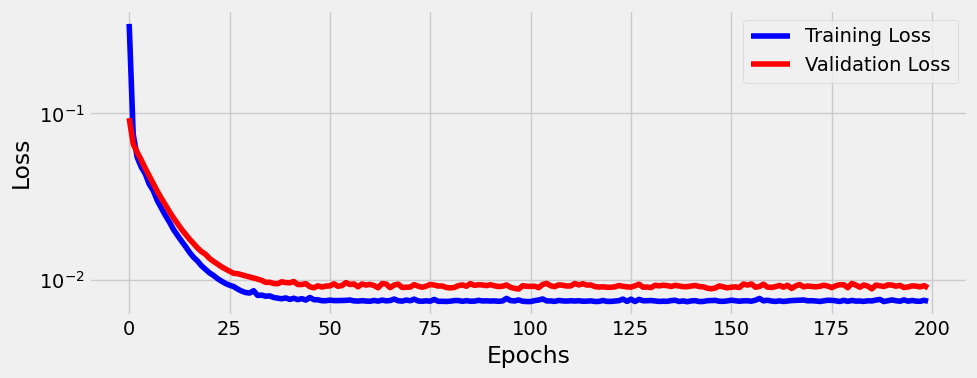

In [47]:
fig = plot_losses(losses, val_losses)

## TensorBoard.

```{index} TensorBoard
```

TensorBoard es un magnifica herramienta a utilizar dentro de deeplearning. En este apartartaddo vamos a manejarla desde dos puntos de vista. Uno en el entorno de Jupyter notebook y otro de forma independiente.

Comenzamos a utilizarla desde Jupyter Notebook, para ello necesitaremos una serie de comandos mágicos, que a continuación se procede a explicar.

Primero incluimos la extensión para jupyter

In [48]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

Y ahora ya podremos usar tensorboard de la siguiente manera

In [49]:
%tensorboard --logdir runs --port=6006

De momento no nos facilita ningún tipo de información ya que no hemos enviado ningún datos a la carpeta *runs*, posteriormente cuando lo hagamos nos ofrecerá diversas opciones muy interesantes para el trabajo con tensores.

También lo podemos activar de forma separada, para ello lo que hay que ejecutar en una linea de comandos es la instrucción: *tensorboard --logdir runs* y entonces en la pantalla de comandos nos aparecerán los siguientes mensajes:

![Tensor Board](figuras/tensorBoard.PNG)

Ahora nos debemos ir a un navegador web e introducir en la barra de direcciones *http://localhost:6006/* para ver en dicho navegador una imagen similar a la que se nos ha presentado anteriormente en una celda de este jupyter.

```{index} SummaryWriter
```

Recordemos que le hemos indicado a tensorFlow que todos nuestros logs para este trabajo se encuentran en la carpeta denominada *runs*. Entonces debemos comenzar por por la creación de un <a href="https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter" target="_blank"> *SummaryWriter* </a>. 

In [50]:
from torch.utils.tensorboard.writer import SummaryWriter

writer = SummaryWriter('runs/test')

SummaryWriter implementa diferentes métodos que permiten enviar información a dashboart

![metodos tensorFlow](figuras/metodoTF.PNG)

También implementa otros dos métodos para la escritura efectiva de datos en disco

* flush

* close

Utilizaremos los dos primeros métodos (add_graph y add_scalars) para enviar el gráfico de nuestro modelo (aunque no es lo mismo que el gráfico de que dibujamos con make_dot...) y, por supuesto, los dos escalares: training y validación losses.

## add_graph.

Añadimos información para tensorboard de la siguiente manera 

In [51]:
writer.add_graph(model)

example_kwarg_inputs should be a dict
Error occurs, No graph saved


RuntimeError: example_kwarg_inputs should be a dict

Como vemos nos genera un error, debido a que necesitamos enviar algún input junto con nuestro modelo. Lo solucionamos de la siguiente manera

In [52]:
# Fetching a tuple of feature (dummy_x) and label (dummy_y)
dummy_x, dummy_y = next(iter(train_loader))
# Since our model was sent to device, we need to do the same
# with the data.
# Even here, both model and data need to be on the same device!
writer.add_graph(model, dummy_x.to(device))


In [53]:
writer.add_scalars('loss', {'training': loss, 'validation': val_loss}, epoch)

Como no me sale lo dejo aquí el tema de tensorboard. Sin embargo sigo actualizando el código

In [54]:
%run -i data_preparation/v2.py

<Figure size 640x480 with 0 Axes>

In [55]:
%%writefile model_configuration/v3.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a SGD optimizer to update the parameters (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step_fn = make_val_step_fn(model, loss_fn)

# Creates a Summary Writer to interface with TensorBoard
writer = SummaryWriter('runs/simple_linear_regression')

# Fetches a single mini-batch so we can use add_graph
x_sample, y_sample = next(iter(train_loader))
writer.add_graph(model, x_sample.to(device))

Overwriting model_configuration/v3.py


In [56]:
%run -i model_configuration/v3.py

In [57]:
%%writefile model_training/v5.py

# Defines number of epochs
n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)
    
    # VALIDATION
    # no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss)
    
    # Records both losses for each epoch under the main tag "loss"
    writer.add_scalars(main_tag='loss',
                       tag_scalar_dict={'training': loss, 'validation': val_loss},
                       global_step=epoch)

# Closes the writer
writer.close()

Overwriting model_training/v5.py


In [58]:
%run -i model_training/v5.py

In [59]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9432]], device='cuda:0')), ('0.bias', tensor([1.0263], device='cuda:0'))])


## Guardando y cargando modelos.

Vamos a proceder ahora a guardar nuestro modelo en un fichero de disco duro denominado *model_checkpoint.pth*.

In [60]:
checkpoint = {'epoch': n_epochs,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': losses,
              'val_loss': val_losses}

torch.save(checkpoint, 'model_checkpoint.pth')

Entonces, si arrancamos de nuevo lo que necesitamos es cargar los códigos de preparación y configuración

In [ ]:
%run -i data_preparation/v2.py
%run -i model_configuration/v3.py

VEamos que aquí el modelo no está entrenado

In [ ]:
print(model.state_dict())

Ahora lo que hacemos es cargar los datos que anteriormente hemos guardado

In [ ]:
checkpoint = torch.load('model_checkpoint.pth')

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

saved_epoch = checkpoint['epoch']
saved_losses = checkpoint['loss']
saved_val_losses = checkpoint['val_loss']

model.train() # always use TRAIN for resuming training

Veamos ahora cuales son los datos del modelo

In [ ]:
print(model.state_dict())

Como podemos obsrvar ahora el modelo si ha cargado adecuadamente.

In [ ]:
%run -i model_training/v5.py

In [ ]:
print(model.state_dict())

## Utilizando clases de Python para construir el modelo.

En lo que sigue, vamos a utilizar la potencia de las clases de Python para integrar todo el código anterior en una clase y así hacer mucho más eficiente el código desarrollado hasta el momento.

Comenzamos importando los módulos necesarios

In [ ]:
import numpy as np
import datetime
import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

comenzamos definiendo la clase

In [ ]:
# A completely empty (and useless) class
class StepByStep(object):
    pass

Comenzamos la clase con el constructor de la misma (__init__). Construimos un método denominado *to* que servirá para enviar los objetos a la GPU si se dispone de la misma

In [ ]:
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)
        # These attributes are defined here, but since they are
        # not available at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0        

        # Creates the train_step function for our model, 
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step = self._make_train_step()
        # Creates the val_step function for our model and loss
        self.val_step = self._make_val_step()
        
    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)
            
    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader 
        # (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to create a SummaryWriter to 
        # interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')
        
    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "b" and "w" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the
            # learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, 
            # since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

Al final el código que queda es el siguiente:

In [ ]:

import numpy as np
import datetime
import torch
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

plt.style.use('fivethirtyeight')

class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        
        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model, 
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to define a SummaryWriter to interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer
        
        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn
    
    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, 
            # since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn
            
    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and 
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None
            
        # Once the data loader and step function, this is the 
        # same mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False    
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            # If a SummaryWriter has been set...
            if self.writer:
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                # Records both losses for each epoch under the main tag "loss"
                self.writer.add_scalars(main_tag='loss',
                                        tag_scalar_dict=scalars,
                                        global_step=epoch)

        if self.writer:
            # Closes the writer
            self.writer.close()

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training   

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval() 
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    def add_graph(self):
        # Fetches a single mini-batch so we can use add_graph
        if self.train_loader and self.writer:
            x_sample, y_sample = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_sample.to(self.device))

vamos ahora a utilizar la clase anterior para poner en marcha nuestro proyecto. Comenzamos cargando los datos, lo hacemos con el programa Python siguiente:


In [ ]:
import numpy as np

true_b = 1
true_w = 2
N = 100

# Data Generation
np.random.seed(42)
x = np.random.rand(N, 1)
y = true_b + true_w * x + (.1 * np.random.randn(N, 1))

# Shuffles the indices
idx = np.arange(N)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:int(N*.8)]
# Uses the remaining indices for validation
val_idx = idx[int(N*.8):]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

In [ ]:
print(x_train.shape)

In [ ]:
print(y_train.shape)

Que lo ejecutamos de la siguiente manera

In [ ]:
# Runs data generation - so we do not need to copy code here
%run -i data_generation/simple_linear_regression.py

Ahora procedemos a preparar los datos

In [ ]:
torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)

Ahora procedemos a la configuración del modelo

In [ ]:
%%writefile model_configuration/v4.py

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1))

# Defines a SGD optimizer to update the parameters
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

In [ ]:
%run -i model_configuration/v4.py

Del código anterior obtenemos los objetos *model, loss function y optimizer* que vamos a pasar la clase creada anteriormente.

In [ ]:
print(model.state_dict())

Ahora ya entramos en el proceso de entrenar el modelo, con el uso de la clase *StepBuStep*.

In [ ]:
sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.set_tensorboard('classy')

In [ ]:
print(sbs.model == model)
print(sbs.model)

Ahora podemos entrenar el modelo por ejemplo con epochs = 200

In [ ]:
sbs.train(n_epochs=200)

In [ ]:
print(model.state_dict()) # remember, model == sbs.model
print(sbs.total_epochs)

In [ ]:
fig = sbs.plot_losses()

También ahora podemos hacer previsiones

In [ ]:
new_data = np.array([.5, .3, .7]).reshape(-1, 1)

In [ ]:
predictions = sbs.predict(new_data)
predictions

In [ ]:
#Hacemos una salvaguarda del modelo
sbs.save_checkpoint('model_checkpoint.pth')

In [ ]:
print(model.state_dict())

Vamos a ver a continuación, cómo cargariamos de nuevo el modelo. 

In [ ]:
new_sbs = StepByStep(model, loss_fn, optimizer)

In [ ]:
print(model.state_dict())

In [ ]:
new_sbs.load_checkpoint('model_checkpoint.pth')
print(model.state_dict())

En resumen y después de todo el desarrollo anterior, con todo lo construido anteriormente, lo que se puede decir es que los pasos a dar para configurar estos modelos son:

* Preparación de los datos (no generación de los mismos)

* Configuración del modelo (función de pérdida, optimizador y modelo)

* Entrenamiento del modelo (utilización de  de la clase StepByStep)

## Ejemplo de uso.

A continuación veamos un ejemplo de datos concretos donde aplicamos lo construido hasta ahora

In [ ]:
import pandas as pd

# cargamos los datos
df = pd.read_csv("datos/Pecan.csv")
df.head()

Hacemos un modelo de regresión lineal simple, para ello seleccionamos las variables correspondientes

In [ ]:
X=df.values[:, 2].reshape(-1,1)
y= df.values[:,3]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# escalamos los valores entre [0,1]
scaler = MinMaxScaler()

X=df.values[:, 2].reshape(-1,1)
X=scaler.fit_transform(X)
y= df.values[:,3].reshape(-1,1)
y=scaler.fit_transform(y)

In [ ]:
# No hacemos la validación
x_train, y_train = X, y

In [ ]:
torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(x_train).float()
y_tensor = torch.as_tensor(y_train).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)


train_loader = DataLoader(dataset=dataset, batch_size=16, shuffle=True)


In [ ]:
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1))

# Defines a SGD optimizer to update the parameters
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

In [ ]:
print(model.state_dict())

In [ ]:
sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader)

In [ ]:
print(sbs.model == model)
print(sbs.model)

In [ ]:
# entrenamos el modelo
sbs.train(n_epochs=200)

In [ ]:
print(model.state_dict()) # remember, model == sbs.model
print(sbs.total_epochs)

Observamos que los parámetros estimados del modelo de regresión son muy similares a los que se han obtenido con estos mismos datos en el tema anterior

In [ ]:
fig = sbs.plot_losses()

## Ejemplo de uso regresión múltiple.

Trabajaremos con la base de datos libre *Boston housing prices* de [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html).

**DESCRIPCIÓN DE LAS VARIABLES DEL DATASET BOSTON HOUSING PRICES:**

* CRIM: Per capita crime rate by town
* ZN: Proportion of residential land zoned for lots over 25,000 sq. ft
* INDUS: Proportion of non-retail business acres per town
* NOX: Nitric oxide concentration (parts per 10 million)
* RM: Average number of rooms per dwelling
* AGE: Proportion of owner-occupied units built prior to 1940
* DIS: Weighted distances to five Boston employment centers
* RAD: Index of accessibility to radial highways
* TAX: full-value property-tax rate per \$10,000
* PTRATIO: Pupil-teacher ratio by town
* B: $1000(B_k — 0.63)^2$, where Bk is the proportion of [people of African American descent] by town
* LSTAT: Percentage of lower status of the population
* MEDV: Median value of owner-occupied homes in \$ $10^3$


---

MEDV es la variable respuesta u objetivo de este problema de regresión  lineal.

In [ ]:
df = pd.read_csv('datos/Bostonraw.csv') 

In [ ]:
df.columns = map(str.lower, df.columns) #convertimos las variables a minúsculas

In [ ]:
# Vemos que no hay ningún valor faltante
df.isnull().sum()

In [ ]:
import seaborn as sns   #seaborn es una extensión de matplotlib
sns.set() 
# Estuiamos los outliers existentes
for column in df:
        plt.figure(figsize=(17,1))
        sns.boxplot(data=df, x=column)

In [ ]:
#definción de la función que nos permitirá eliminar los outliers 
#para cada variable (columna)
def eliminar_outlier(col): 
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lowerthr= Q1-(1.5 * IQR) #UMBRAL INFERIOR
    upperthr= Q3+(1.5 * IQR) #UMBRAL SUPERIOR
    return lowerthr,upperthr

In [ ]:
for column in df.columns: #aplicamos la función eliminar_outlier para cada variable (columna) del dataframe
    if df[column].dtype != 'object': 
        lowerthr,upperthr=eliminar_outlier(df[column])
        df[column]=np.where(df[column]>upperthr,upperthr,df[column])
        df[column]=np.where(df[column]<lowerthr,lowerthr,df[column])

In [ ]:
for column in df:
        plt.figure(figsize=(17,1))
        sns.boxplot(data=df, x=column)

### Estandarización de los datos

Hacemos un cambio de variable para que los datos tengan una media de cero y desviación típica de uno. Hacemos primero una copia de los datos.

In [ ]:
dfestand=df.copy()
dfestand.columns

In [ ]:
from sklearn.preprocessing import StandardScaler #importamos la librería para estandarizar
scalerX = StandardScaler()
lista_columnas=['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat']
dfestand[lista_columnas] = scalerX.fit_transform(dfestand[lista_columnas])

Estandarizamos la variable respuesta u objetivo (variable dependiente, **Y**)

In [ ]:
scalerY = StandardScaler()
dfestand['medv']=scalerY.fit_transform(np.array(dfestand['medv']).reshape(len(dfestand['medv']),1)).reshape(len(dfestand['medv']))

Creamos las variables explicativas X e Y

In [ ]:
X = dfestand.drop(['medv'],axis=1).values
Y = dfestand['medv'].values
Y = Y.reshape(-1,1)
print("Dimensión de X:",X.shape)
print("Dimensión de Y", Y.shape)

In [ ]:
# pasamos los datos anteriores a tensores
x_tensor = torch.as_tensor(X).float()
y_tensor = torch.as_tensor(Y).float()

dataset = TensorDataset(x_tensor,y_tensor)

# Hacemos el split de los datos
ratio = 0.8
n_total = len(dataset)
n_train = int(n_total*ratio)
n_val = n_total-n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

# creamos el DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16, shuffle=True)

In [ ]:
type(val_data)

Configuremos ahora el modelo

In [ ]:
# Coeficiente de aprendizaje
lr=0.1

torch.manual_seed(42)
# creamos el modelo
par_entrada = X.shape[1] # es el número de variables predictoras
model = nn.Sequential(nn.Linear(par_entrada, 1))

optimizer = optim.SGD(model.parameters(), lr=lr)

loss_fn = nn.MSELoss(reduction='mean')

In [ ]:
print(model.state_dict())

Hemos definido los datos y la configuración del modelo, ahora procedemos a su entrenamiento

In [ ]:
sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)

In [ ]:
print(sbs.model == model)
print(sbs.model)

In [ ]:
sbs.train(n_epochs=80)

In [ ]:
print(model.state_dict()) # remember, model == sbs.model

In [ ]:
fig = sbs.plot_losses()

Ahora si queremos hacer predicciones, tenemos que pasar los datos de validación *val_dat* a un array numpy. Para obtener esto debemos ejecutar el siguiente código

In [ ]:
dat_val = val_data.dataset.tensors[0].numpy()

In [ ]:
sbs.predict(dat_val)

Y ahora ya podemos obtener los indicadores de ajuste del modelo que deseemos (MAE,MSE, etc).

## Apéndice.

* <a href="https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/?utm_source=drip&utm_medium=email&utm_campaign=Text+Generation+with+LSTM+in+PyTorch&utm_content=Text+Generation+with+LSTM+in+PyTorch" target="_blank"> Un resumen de creación código PyTorch </a>